In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
from sklearn.model_selection import train_test_split

In [30]:
class Zonotope:
    def __init__(self, centre, generators):
        self.centre = np.array(centre).reshape(-1)         # shape (n,)
        self.generators = np.atleast_2d(generators)        # shape (n, m)
        if self.generators.shape[0] != self.centre.shape[0]:
            raise ValueError("Generators must have same dimension as centre")
        self.d = self.centre.shape[0]   # dimension
        self.m = self.generators.shape[1]  # number of generators

    def minkowski_sum(self, other):
        new_centre = self.centre + other.centre
        new_generators = np.hstack((self.generators, other.generators))
        return Zonotope(new_centre, new_generators)
    
    def subtract(self, other):
        new_centre = self.centre - other.centre
        new_generators = np.hstack((self.generators, -other.generators))
        return Zonotope(new_centre, new_generators)
    
    @classmethod
    def from_intervals(cls, lower, upper):
        lower = np.array(lower).reshape(-1)
        upper = np.array(upper).reshape(-1)

        if lower.shape != upper.shape:
            raise ValueError("Lower and upper must have same shape")

        centre = (lower + upper) / 2
        radii = (upper - lower) / 2

        generators = np.diag(radii)
        return cls(centre, generators)
    
    def output_interval(self):
        radius = np.sum(np.abs(self.generators), axis=1)  # sum across generators
        lower = self.centre - radius
        upper = self.centre + radius
        return lower, upper

    def affine_map(self, A, b=None):
            # Ensure centre is a column vector for matrix multiplication
            new_centre = A @ self.centre
            if b is not None:
                new_centre = new_centre + np.array(b).reshape(-1)
            new_generators = A @ self.generators
            return Zonotope(new_centre, new_generators)
    
    def __repr__(self):
        return f"Zonotope(dim={self.d}, generators={self.m})\nCentre:\n{self.centre}\nGenerators:\n{self.generators}"

### Data

In [31]:
df = pd.read_csv('Data/AmesHousing.csv')
df.head()

y = df['SalePrice'].values

Delta = np.abs(np.random.normal(15000, 10000, len(df)))
b = np.random.uniform(-1, 1, size=len(df))

m = y + b * Delta

df['SALEPRICE_LOWER'] = m - Delta
df['SALEPRICE_UPPER'] = m + Delta

X = df['Year Built']

X_train, X_test, y_train, y_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(
    X, y, df['SALEPRICE_LOWER'].values, df['SALEPRICE_UPPER'].values, test_size=0.2, random_state=42
)




df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,SALEPRICE_LOWER,SALEPRICE_UPPER
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,5,2010,WD,Normal,215000,208701.487711,217502.682334
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,MnPrv,NaN,0,6,2010,WD,Normal,105000,99017.344351,146440.294203
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,Gar2,12500,6,2010,WD,Normal,172000,135919.556301,200551.674781
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,4,2010,WD,Normal,244000,205086.788737,269857.813366
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,MnPrv,NaN,0,3,2010,WD,Normal,189900,180838.724239,234715.849736


### Regression

In [32]:
def polynomial_basis(X, degree=5):
    X = np.asarray(X).flatten()
    X_scaled = (X - X.min()) / (X.max() - X.min())
    Phi = np.column_stack([X_scaled**i for i in range(degree+1)])
    return Phi

def nonlinear_zonotope_bounds(
    X,
    y_lower,
    y_upper,
    x_grid=None,
    degree=10,
    alpha=0.05
):
    X = np.asarray(X).flatten()
    y_lower = np.asarray(y_lower).flatten()
    y_upper = np.asarray(y_upper).flatten()

    Phi = polynomial_basis(X, degree)
    print(Phi.shape)

    PhiTPhi = Phi.T @ Phi
    PhiT_inv = np.linalg.inv(PhiTPhi)
    M = PhiT_inv @ Phi.T

    Y_zono = Zonotope.from_intervals(y_lower, y_upper)
    Beta_zono = Y_zono.affine_map(M)

    if x_grid is None:
        return Beta_zono

    Phi_grid = polynomial_basis(x_grid, degree)
    Yhat_zono = Beta_zono.affine_map(Phi_grid)
    y_lower_zono, y_upper_zono = Yhat_zono.output_interval()

    return (
        Beta_zono,
        Yhat_zono,
        y_lower_zono,
        y_upper_zono,
    )

(2344, 4)


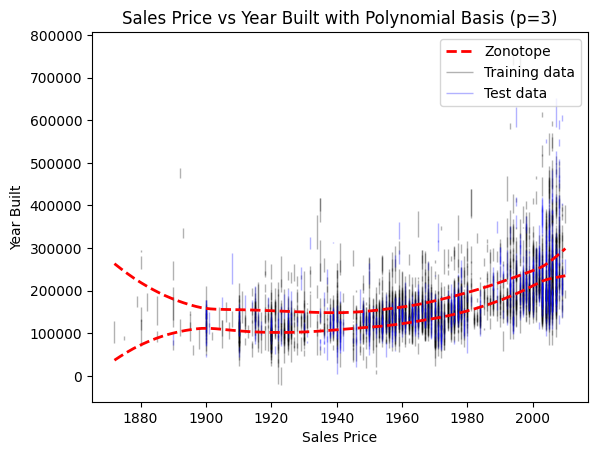

In [33]:
x_grid = np.linspace(X_train.min(), X_train.max(), len(X_train))

_, y_pred, y_min, y_max = nonlinear_zonotope_bounds(X_train, y_lower_train, y_upper_train, x_grid, degree=3)


plt.plot(x_grid, y_min, '--r', label='Zonotope', linewidth=2, zorder=2)
plt.plot(x_grid, y_max, '--r', linewidth=2, zorder=2)



for i in range(len(X_train)):
    label = 'Training data' if i == 0 else None
    plt.vlines(
        x=X_train.iloc[i],
        ymin=y_lower_train[i], 
        ymax=y_upper_train[i],
        colors='black',
        alpha=0.3,
        linewidth=1,
        label=label,
        zorder=1
    )

# Plot test intervals in blue
for i in range(len(X_test)):
    label = 'Test data' if i == 0 else None
    plt.vlines(
        x=X_test.iloc[i],
        ymin=y_lower_test[i], 
        ymax=y_upper_test[i],
        colors='blue',
        alpha=0.3,
        linewidth=1,
        label=label,
        zorder=1
    )
    
plt.legend()
plt.title('Sales Price vs Year Built with Polynomial Basis (p=3)')
plt.xlabel('Sales Price')
plt.ylabel('Year Built')

plt.savefig("HousePrices.pdf", bbox_inches="tight")
plt.show()